In [22]:
import os
from dotenv import load_dotenv
from pyprojroot import here
load_dotenv()

True

### Environment setup

In [23]:
# os.environ['OPENAI_API_KEY'] = os.getenv("OPEN_AI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

### Tools

In [109]:
from accord.agent_graph.tool_rag import RAGTool
from accord.agent_graph.tool_sql import query_sqldb
from accord.agent_graph.tool_tavely_search import load_tavily_search_tool
RAGTool()
search_tool = load_tavily_search_tool(2)

tools = [search_tool] + [query_sqldb] + RAGTool.tools
tools

2025-02-12 19:29:14 | INFO     | accord.agent_graph.tool_rag:create_tools:67 - Tool test_doc created successfully
2025-02-12 19:29:14 | INFO     | accord.agent_graph.tool_rag:create_tools:67 - Tool swiss_airline_policy created successfully
2025-02-12 19:29:14 | INFO     | accord.agent_graph.tool_rag:create_tools:67 - Tool stories created successfully


[TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 StructuredTool(name='query_sqldb', description='Query the  SQL Database. Input should be a search query.', args_schema=<class 'langchain_core.utils.pydantic.query_sqldb'>, func=<function query_sqldb at 0x77055cd4c720>),
 StructuredTool(name='test_doc', description='Search about Bangladesh and its details.\nAlso have some information git repo RAG-DeepSeek-r1', args_schema=<class 'langchain_core.utils.pydantic.test_doc'>, func=<function test_doc at 0x770543da5a80>),
 StructuredTool(name='swiss_airline_policy', description='Consult the company policies to check whether certain options are permitted.', args_schema=<class 'langchain_core.utils.pydantic.swiss_airline_policy'>, func=<function swiss_airline_policy at 0x770502b4b600>),
 StructuredTool(name='stories', description='Search among the fictional stories and find the answer to the query. Input should be the query.', args_s

### Gemini LLM

In [25]:
from langchain_google_genai import GoogleGenerativeAI

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
# Initialize Gemini Pro
llm = GoogleGenerativeAI(model="gemini-pro")

In [110]:
from langchain.agents import initialize_agent, AgentType
# Tell the LLM which tools it can call
llm_with_tools = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True
) | (lambda x: x.get("output","sorry, i think i am not able to help you with that"))

In [111]:
llm_with_tools.invoke("hi")



> Entering new AgentExecutor chain...


/home/yato/ML/Agentic-Chatbot/env/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(id='a02fc50e-373e-44a2-b8da-26d09701ed4c', metadata={'source': 'data/unstructured_docs/test_doc/test.md'}, page_content='## Use Cases\n- **Document Q&A**: Ask questions and get precise answers from unstructured documents.\n- **RAG (Retrieval-Augmented Generation)**: Retrieve relevant information and generate context-aware responses.\n\n## Getting Started\nTo get started with **rag-deepseek-r1**, follow the instructions in the [Installation Guide](#installation) \n\n**Key Note:** Before running the RAG chatbot, you should first install [Ollama](https://ollama.com/download) and the [Deepseek model on Ollama](https://ollama.com/library/deepseek-r1).\n```\nollama run deepseek-r1:1.5b\nollama run deepseek-r1:7b\nollama run deepseek-r1:8b\n```\n\n## Installation\n1. Clone the repository:\n   ```bash\n   git clone https:

I can greet the user.
Action: test_doc
Action Input: hi
Observation: 
Thought:Final Answer: Hi there! How can I help you today?

> Finished chain.


'Hi there! How can I help you today?'

### Groq

In [112]:
from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
# llm = ChatGroq(model_name="deepseek-r1-distill-llama-70b")
llm = ChatGroq(model_name="llama3-8b-8192")

In [113]:
llm_with_tools = llm.bind_tools(tools)

### Graph

In [114]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [115]:
def chatbot(state: State):
    print(f"chatbot: {state}")
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [116]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        print(f"BasicToolNode: {inputs}")
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [117]:
from langgraph.graph import END, MessagesState
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    print(f"should_continue: {state}")
    messages = state['messages']
    print(f"should_continue: {messages}")
    last_message = messages[-1]
    print(f"last_message: {last_message}")
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    ["tools", END],
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [118]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

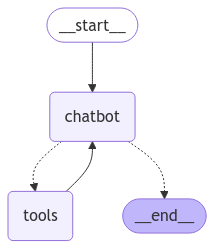

In [119]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [120]:
config = {"configurable": {"thread_id": "1"}}

In [121]:
user_input = "Hi there! My name is Farzad."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Farzad.
chatbot: {'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8362-f25029f2b814')]}
should_continue: {'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8362-f25029f2b814'), AIMessage(content='Hello Farzad! Nice to meet you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1370, 'total_tokens': 1381, 'completion_time': 0.009166667, 'prompt_time': 0.276764109, 'queue_time': 0.289156047, 'total_time': 0.285930776}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-589154b7-c894-48c7-accd-9bfded8ea0e0-0', usage_metadata={'input_tokens': 1370, 'output_tokens': 11, 'total_tokens': 1381})]}
should_co

In [122]:
from langchain_core.messages import HumanMessage
user_input = "Hi there! My name is Farzad."

# Use the Runnable
final_state = graph.invoke(
    {"messages": [HumanMessage(content=user_input)]},
    config=config
)
final_state["messages"][-1].content

chatbot: {'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8362-f25029f2b814'), AIMessage(content='Hello Farzad! Nice to meet you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1370, 'total_tokens': 1381, 'completion_time': 0.009166667, 'prompt_time': 0.276764109, 'queue_time': 0.289156047, 'total_time': 0.285930776}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-589154b7-c894-48c7-accd-9bfded8ea0e0-0', usage_metadata={'input_tokens': 1370, 'output_tokens': 11, 'total_tokens': 1381}), HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='c4bcb7d3-99c7-49da-9f7b-8b07d1beef2e')]}
should_continue: {'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8

'Nice to meet you, Farzad!'

In [123]:
user_input = "Can I cancel my ticket 10 hours before the flight?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can I cancel my ticket 10 hours before the flight?
chatbot: {'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8362-f25029f2b814'), AIMessage(content='Hello Farzad! Nice to meet you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1370, 'total_tokens': 1381, 'completion_time': 0.009166667, 'prompt_time': 0.276764109, 'queue_time': 0.289156047, 'total_time': 0.285930776}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-589154b7-c894-48c7-accd-9bfded8ea0e0-0', usage_metadata={'input_tokens': 1370, 'output_tokens': 11, 'total_tokens': 1381}), HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='c4bcb7d3-99c7-49da-9f7b-8b07d1beef2e'), AIMessage(content='N

No relevant docs were retrieved using the relevance score threshold 0.4


should_continue: {'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8362-f25029f2b814'), AIMessage(content='Hello Farzad! Nice to meet you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1370, 'total_tokens': 1381, 'completion_time': 0.009166667, 'prompt_time': 0.276764109, 'queue_time': 0.289156047, 'total_time': 0.285930776}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-589154b7-c894-48c7-accd-9bfded8ea0e0-0', usage_metadata={'input_tokens': 1370, 'output_tokens': 11, 'total_tokens': 1381}), HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='c4bcb7d3-99c7-49da-9f7b-8b07d1beef2e'), AIMessage(content='Nice to meet you, Farzad!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens':

In [125]:
user_input = "Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate
chatbot: {'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8362-f25029f2b814'), AIMessage(content='Hello Farzad! Nice to meet you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1370, 'total_tokens': 1381, 'completion_time': 0.009166667, 'prompt_time': 0.276764109, 'queue_time': 0.289156047, 'total_time': 0.285930776}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-589154b7-c894-48c7-accd-9bfded8ea0e0-0', usage_metadata={'input_tokens': 1370, 'output_tokens': 11, 'total_tokens': 1381}), HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='c4b

In [126]:
event

{'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='3ab8fa8f-a9d7-4cdc-8362-f25029f2b814'),
  AIMessage(content='Hello Farzad! Nice to meet you!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 1370, 'total_tokens': 1381, 'completion_time': 0.009166667, 'prompt_time': 0.276764109, 'queue_time': 0.289156047, 'total_time': 0.285930776}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-589154b7-c894-48c7-accd-9bfded8ea0e0-0', usage_metadata={'input_tokens': 1370, 'output_tokens': 11, 'total_tokens': 1381}),
  HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='c4bcb7d3-99c7-49da-9f7b-8b07d1beef2e'),
  AIMessage(content='Nice to meet you, Farzad!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 1400, 'tot